# Para rodar esse notebook primeiramente rode o mortalidade.ipynb

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as py

In [2]:
mort = pd.read_csv('mortalidadeAjustada.csv')

In [3]:
df_covid = pd.read_csv('dataset-covid19.csv')
df_covid = df_covid[['state', 'city', 'place_type', 'city_ibge_code', 'last_available_confirmed', 'last_available_deaths', 'last_available_death_rate', 'estimated_population', 'last_available_confirmed_per_100k_inhabitants']]

df_covid = df_covid[df_covid.place_type == 'city'] ## Filtra para pegar apenas dados de cidades
df_covid.isnull().sum() ## Realiza a contagem de quantos valores nulos temos

df_covid = df_covid[df_covid.city != 'Importados/Indefinidos'] ## Remoção das linhas em branco

df_covid['city_ibge_code'] = df_covid['city_ibge_code'].astype(int) ## Conversão da coluna para inteiro

df_covid= df_covid.rename(columns={'state': 'UF'}) ## Trocando o nome de state para UF
df_covid= df_covid.rename(columns={'city': 'Nome do município'}) ## Trocando o nome de city para Nome do município
df_covid['UF-City'] = df_covid['UF'] + df_covid['Nome do município']
df_covid

,UF,Nome do município,place_type,city_ibge_code,last_available_confirmed,last_available_deaths,last_available_death_rate,estimated_population,last_available_confirmed_per_100k_inhabitants,UF-City
6,DF,Brasília,city,5300108,205366,3678,0.0179,3055149.0,6721.96348,DFBrasília
10,GO,Abadia de Goiás,city,5200050,729,7,0.0096,8958.0,8137.97723,GOAbadia de Goiás
11,GO,Abadiânia,city,5200100,184,12,0.0652,20461.0,899.27179,GOAbadiânia
12,GO,Acreúna,city,5200134,1032,25,0.0242,22546.0,4577.30861,GOAcreúna
13,GO,Adelândia,city,5200159,87,2,0.0230,2516.0,3457.86963,GOAdelândia
...,...,...,...,...,...,...,...,...,...,...
5610,RS,Vista Alegre do Prata,city,4323606,44,0,0.0000,1557.0,2825.94733,RSVista Alegre do Prata
5611,RS,Vista Gaúcha,city,4323705,62,1,0.0161,2855.0,2171.62872,RSVista Gaúcha
5612,RS,Vitória das Missões,city,4323754,22,0,0.0000,3092.0,711.51358,RSVitória das Missões
5613,RS,Westfália,city,4323770,90,0,0.0000,3031.0,2969.31706,RSWestfália


In [4]:
df_inter = pd.read_csv('dataset-inter.csv') ## Lê o dataset

df_inter = df_inter.dropna() ## Remove os dados nulos

df_inter= df_inter.rename(columns={'estadoSigla': 'UF'}) ## Renomeia a coluna estadoSigla para UF
df_inter= df_inter.rename(columns={'municipio': 'Nome do município'}) ## Renomeia a coluna municipio para Nome do município

df_inter['UF-City'] = df_inter['UF'] + df_inter['Nome do município']  ##Cria uma nova coluna para diferencias cada cidade

In [5]:
## Realiza o groupby para unificar os dados de uma mesma cidade
df_inter = df_inter.groupby([df_inter['UF-City'], df_inter['UF'], df_inter['Nome do município']]).sum()
df_inter = df_inter.reset_index()

## Cria as duas novas colunas da taxa de ocupação
df_inter["taxa ocupado SRAG uti"] = df_inter["ocupSRAGUti"] / df_inter["ofertaSRAGUti"]
df_inter["taxa ocupado SRAG cli"] = df_inter["ocupSRAGCli"] / df_inter["ofertaSRAGCli"]


df_pop_estimada = df_covid[['UF', 'Nome do município', 'estimated_population']]
df_inter = pd.merge(df_inter,df_pop_estimada, on=["Nome do município", "UF"])

## Devemos normalizar o número de respitadores e vagas ofertadas pela popualação da cidade

df_inter['ofertaRespiradores'] = df_inter['ofertaRespiradores'] / df_inter['estimated_population']
df_inter['ofertaHospCli'] = df_inter['ofertaHospCli'] / df_inter['estimated_population'] 
df_inter['ofertaHospUti'] = df_inter['ofertaHospUti'] / df_inter['estimated_population'] 
df_inter['ofertaSRAGCli'] = df_inter['ofertaSRAGCli'] / df_inter['estimated_population'] 
df_inter['ofertaSRAGUti'] = df_inter['ofertaSRAGUti'] / df_inter['estimated_population'] 

## Devemos normalizar a ocupação do hospital pela quantidade ocupada

df_inter['ocupHospCli'] = df_inter['ocupHospCli'] / df_inter['ofertaHospCli'] 
df_inter['ocupHospUti'] = df_inter['ocupHospUti'] / df_inter['ofertaHospUti'] 
df_inter['ocupHospUti'] = df_inter['ocupHospUti'] / df_inter['ofertaSRAGCli'] 
df_inter['ocupSRAGUti'] = df_inter['ocupSRAGUti'] / df_inter['ofertaSRAGUti'] 


##Identifica os extremos (infinitos) e substitui por 0
df_inter[df_inter==np.inf]  = np.nan
df_inter[df_inter== -np.inf] = np.nan
df_inter["taxa ocupado SRAG uti"].fillna(0, inplace=True)
df_inter["taxa ocupado SRAG cli"].fillna(0, inplace=True)

df_inter["ocupHospCli"].fillna(0, inplace=True)
df_inter["ocupHospUti"].fillna(0, inplace=True)
df_inter["ocupHospUti"].fillna(0, inplace=True)
df_inter["ocupSRAGUti"].fillna(0, inplace=True)

df_inter

,UF-City,UF,Nome do município,ofertaRespiradores,ofertaHospCli,ofertaHospUti,ofertaSRAGCli,ofertaSRAGUti,ocupHospCli,ocupHospUti,ocupSRAGCli,ocupSRAGUti,altas,obitos,ocupacaoInformada,algumaOcupacaoInformada,taxa ocupado SRAG uti,taxa ocupado SRAG cli,estimated_population
0,ACAcrelândia,AC,Acrelândia,0.000000,0.001033,0.000000,0.000258,0.000000,0.000000,0.000000e+00,3.0,0.00000,0.0,0.0,1.0,1.0,0.00000,0.750000,15490.0
1,ACAssis Brasil,AC,Assis Brasil,0.000000,0.001593,0.000000,0.000265,0.000000,0.000000,0.000000e+00,1.0,0.00000,60.0,8.0,1.0,1.0,0.00000,0.500000,7534.0
2,ACCruzeiro do Sul,AC,Cruzeiro do Sul,0.000067,0.001504,0.000090,0.000483,0.000112,27253.373134,4.612687e+07,41.0,62350.40000,4.0,0.0,2.0,2.0,0.70000,0.953488,89072.0
3,ACRio Branco,AC,Rio Branco,0.000155,0.001120,0.000058,0.000370,0.000097,168760.263499,7.912706e+08,108.0,434088.90000,17.0,7.0,4.0,4.0,1.05000,0.705882,413418.0
4,ALArapiraca,AL,Arapiraca,0.000150,0.001334,0.000099,0.000442,0.000137,52454.308682,6.189930e+08,32.0,94675.34375,3.0,0.0,3.0,3.0,0.40625,0.310680,233047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,TOPalmas,TO,Palmas,0.000313,0.002896,0.000225,0.000082,0.000065,203391.594138,6.254483e+09,22.0,459444.00000,3.0,1.0,9.0,9.0,1.50000,0.880000,306296.0
1951,TOParaíso do Tocantins,TO,Paraíso do Tocantins,0.000096,0.001715,0.000000,0.000674,0.000000,15159.168539,0.000000e+00,2.0,0.00000,1.0,0.0,1.0,1.0,0.00000,0.057143,51891.0
1952,TOPedro Afonso,TO,Pedro Afonso,0.000000,0.002323,0.000000,0.000581,0.000000,2582.437500,0.000000e+00,2.0,0.00000,0.0,0.0,1.0,1.0,0.00000,0.250000,13773.0
1953,TOPorto Nacional,TO,Porto Nacional,0.000094,0.002832,0.000000,0.000356,0.000000,16595.046358,0.000000e+00,3.0,0.00000,2.0,0.0,2.0,2.0,0.00000,0.157895,53316.0


In [6]:
df = pd.merge(df_inter, df_covid, on='UF-City')

In [7]:
pivot = pd.read_csv('dataset-codigos-ibge.csv')
df = df.merge(pivot, left_on='city_ibge_code', right_on='id_municipio')

In [8]:
df = df.merge(mort, left_on='id_municipio_6', right_on='Código do Município')

In [9]:
df = df[df['Mortalidade'] != 0]

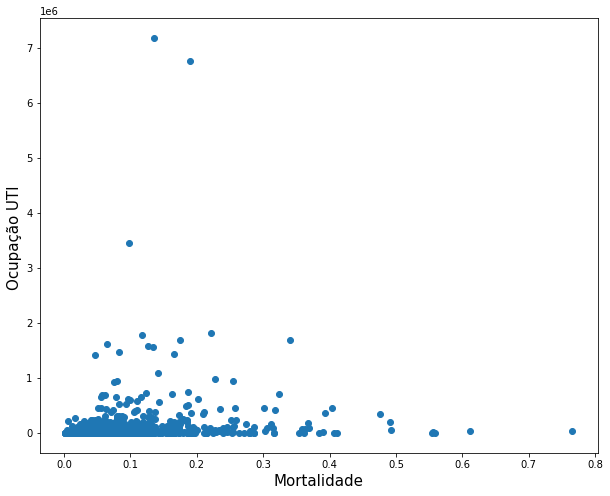

In [10]:
py.figure(figsize=[10,8])
py.ylabel('Ocupação UTI ', fontsize=15)
py.xlabel('Mortalidade', fontsize=15)
py.scatter(df['Mortalidade'], df['ocupSRAGUti'])

py.savefig('mort_ocup.png')

In [11]:
df['Mortalidade'].corr(df['ocupSRAGUti'])

0.18610038549213576

In [12]:
ivc = pd.read_excel('IVC.xlsx')

In [13]:
df = df.rename(columns={'Nome do município_x': 'Nome do município', 'UF_x': 'UF'})
df = pd.merge(df, ivc, on=['Nome do município', 'UF'])

In [14]:
df = df.rename(columns={'ÍNDICE DE VULNERABILIDADE AO COVID-19V     (IVC)': 'IVC'})

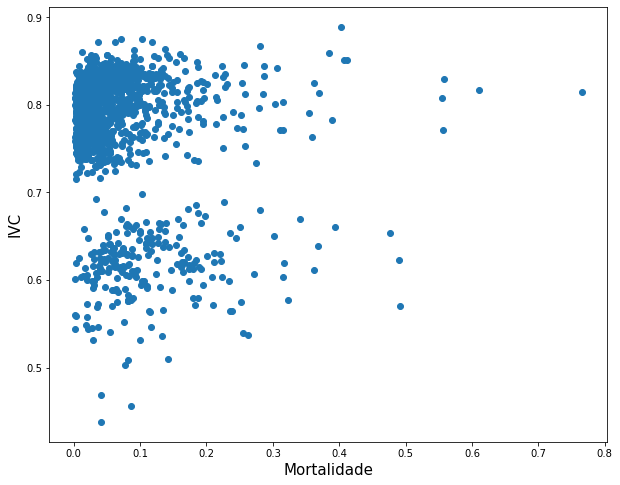

In [15]:
py.figure(figsize=[10,8])

py.ylabel('IVC', fontsize=15)
py.xlabel('Mortalidade', fontsize=15)
py.scatter(df['Mortalidade'], df['IVC'])

py.savefig('mort_ocup.png')

In [16]:
df['Mortalidade'].corr(df['IVC'])

-0.18365958653040745